# Mental Health Insights on Working Environment







## Section 1: Business Understanding

This analysis aims to explore the [Stack Overflow 2022 survey results](https://insights.stackoverflow.com/survey) dataset results related to mental health in the workplace, answering six key questions related to the prevalence of mental health:


1. What is the prevalence of mental health answers among employed professionals?
2. What is the country-specific prevalence of mental health answers among employed professionals?
3. What is the work-model-specific prevalence of mental health answers among employed professionals?
4. What is the developer-type-specific prevalence of mental health answers among employed professionals?
5. What is the organization’s size-specific prevalence of mental health answers among employed professionals?
6. What is the age-specific prevalence of mental health answers among employed professionals?

The goal is to provide statistical and visual insights to help organizations prioritize mental health programs and initiatives. The graphs demonstrate the importance of prioritizing mental health programs in the workplace and supporting the workforce’s overall well-being.

## Section 2: Data understanding

### Gethering the dataset

Importing some libs and loading the local CSV dataset file.

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

In [ ]:
# Importing local CSV dataset file
df = pd.read_csv('./stack-overflow-developer-survey-2022/survey_results_public.csv')

# Creating a auxiliary variable for the total dataset length - later usage
df_len = len(df)

### Understanding the gathered data

Let's check the dataset information like:
- Dataset shape
- Categorical and Numerical Columns
- Columns names
- Basics numerical columns stats

In [ ]:
# Dataset shape
print('#' * 25)
print('Dataframe shape: {}'.format(df.shape))

# Checking the Continuous and Categorical columns in the dataset
con_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(exclude='number').columns
print('\n' + '#' * 25)
print('The dataset contains:')
print('- {} Continuous colunmns'.format(len(con_cols)))
print('- {} Categorical colunmns'.format(len(cat_cols)))

# Printing the dataset columns names
print('\n' + '#' * 25)
print('Dataset columns:')
print(df.columns.values)

# Printing the dataset basic stats
print('\n' + '#' * 25)
print('Basic stats of the numerical columns:')
df.describe()

#########################
Dataframe shape: (73268, 79)

#########################
The dataset contains:
- 6 Continuous colunmns
- 73 Categorical colunmns

#########################
Dataset columns:
['ResponseId' 'MainBranch' 'Employment' 'RemoteWork' 'CodingActivities'
 'EdLevel' 'LearnCode' 'LearnCodeOnline' 'LearnCodeCoursesCert'
 'YearsCode' 'YearsCodePro' 'DevType' 'OrgSize' 'PurchaseInfluence'
 'BuyNewTool' 'Country' 'Currency' 'CompTotal' 'CompFreq'
 'LanguageHaveWorkedWith' 'LanguageWantToWorkWith'
 'DatabaseHaveWorkedWith' 'DatabaseWantToWorkWith'
 'PlatformHaveWorkedWith' 'PlatformWantToWorkWith'
 'WebframeHaveWorkedWith' 'WebframeWantToWorkWith'
 'MiscTechHaveWorkedWith' 'MiscTechWantToWorkWith'
 'ToolsTechHaveWorkedWith' 'ToolsTechWantToWorkWith'
 'NEWCollabToolsHaveWorkedWith' 'NEWCollabToolsWantToWorkWith'
 'OpSysProfessional use' 'OpSysPersonal use' 'VersionControlSystem'
 'VCInteraction' 'VCHostingPersonal use' 'VCHostingProfessional use'
 'OfficeStackAsyncHaveWorkedWith

,ResponseId,CompTotal,VCHostingPersonal use,VCHostingProfessional use,WorkExp,ConvertedCompYearly
count,73268.000000,3.842200e+04,0.0,0.0,36769.000000,3.807100e+04
mean,36634.500000,2.342434e+52,NaN,NaN,10.242378,1.707613e+05
std,21150.794099,4.591478e+54,NaN,NaN,8.706850,7.814132e+05
min,1.000000,0.000000e+00,NaN,NaN,0.000000,1.000000e+00
25%,18317.750000,3.000000e+04,NaN,NaN,4.000000,3.583200e+04
50%,36634.500000,7.750000e+04,NaN,NaN,8.000000,6.784500e+04
75%,54951.250000,1.540000e+05,NaN,NaN,15.000000,1.200000e+05
max,73268.000000,9.000000e+56,NaN,NaN,50.000000,5.000000e+07


Below, you can find the total of the unique categorical values for each selected column, columns that were selected based on the previous cells analysis, in order to answer the business questions.

In [ ]:
# Printing the selected columns counted values, dopping the null counts
print('Pre-selected columns counted values:')
selected_cols = ['Country', 'MentalHealth', 'Employment', 'RemoteWork', 'DevType']
for c in selected_cols:
  col_values_len = len(df[c].str.split(';').explode().value_counts())
  print('- {} = {}'.format(c, col_values_len))

Pre-selected columns counted values:
- Country = 180
- MentalHealth = 8
- Employment = 9
- RemoteWork = 3
- DevType = 29


Once you get familiar yourself with the dataset, it gets easier to answer business-related questions using the data, including categorical ones. In the following plots, we have counted the unique values for each pre-selected column to visualize the distribution of categorical values.

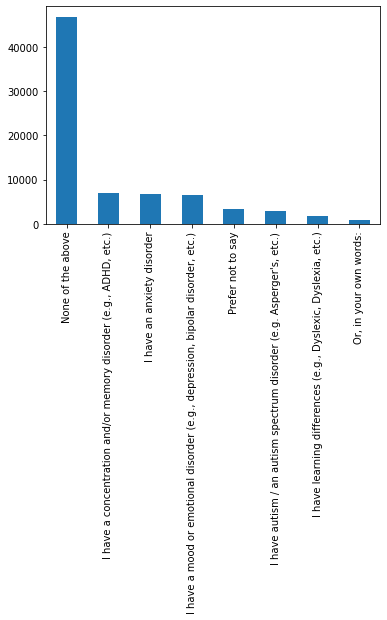

In [ ]:
df['MentalHealth'].str.split(';').explode().value_counts().plot(kind='bar');

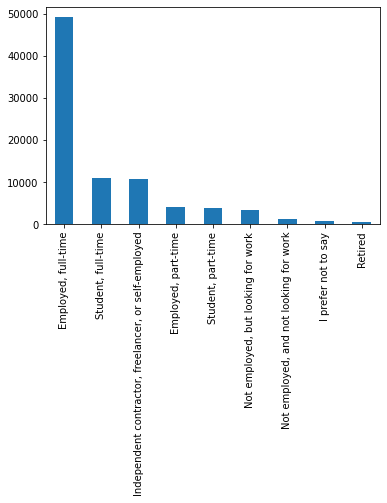

In [ ]:
df['Employment'].str.split(';').explode().value_counts().plot(kind='bar');

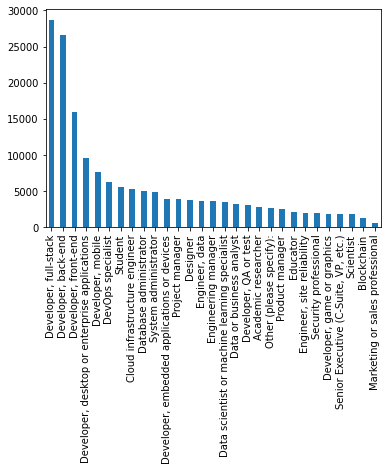

In [ ]:
df['DevType'].str.split(';').explode().value_counts().plot(kind='bar');

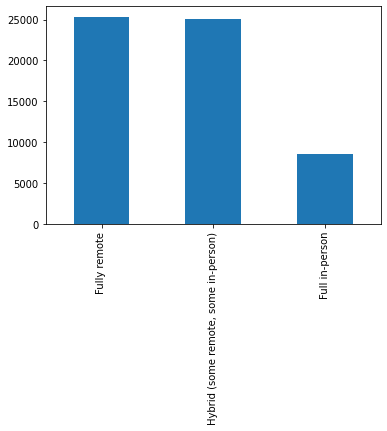

In [ ]:
df['RemoteWork'].value_counts().plot(kind='bar');

## Section 3: Data Preparation

### Creating Mental Health subset

Let's create a subset from our dataset that contains only the developers' answers with Mental Health occurrences.

In [ ]:
# Mental Health filters:
# - The "MentalHealth" column is not null
# - End not equals to "None of the above"
# - End not equals to "Prefer not to say"
not_null = df['MentalHealth'].notna()
not_none = df['MentalHealth'] != 'None of the above'
not_not_say = df['MentalHealth'] != 'Prefer not to say'

# Required due to the focus on Mental Health answers only
df_mh = df.loc[not_null & not_none & not_not_say]

### Creating Professional with Mental Health answers subset

And from this first Mental Health subset, let's create another subset only for professionals that are full-time employers.

In [ ]:
# Professionals filter
# - Where the "Employment" column is "Employed, full-time" 
# - And the "YearsCodePro" column is not null
is_full_time = df_mh['Employment'] == 'Employed, full-time'
has_pro_year = df_mh['YearsCodePro'].notna()

# These filters were necessary to ensure the analysis focused 
# on employed professionals exclusively, enabling the 
# extract valuable insights specific to this population
df_mh_pro = df_mh.loc[is_full_time & has_pro_year]

In [ ]:
# Finding the length of Employed Professionals with the Mental Health answers - later usage
df_mh_pro_len = len(df_mh_pro)

## Section 4: Evaluation

### 1. What is the prevalence of mental health answers among employed professionals?

To understand the scale of the problem, it's important to understand the percentage of employment professionals reporting mental health problems.

The below cells calculates the percentage of respondents with specific mental health problems (depression, anxiety, ADHD) and the overall percentage of respondents with mental health problems. Then create a bar chart of percentages and errors for each mental health issue and add percentage text for each individual item also the 95% confidence level associated errors.

In [ ]:
def get_mental_health_stats(mental_health=None):
  """
  Calculates the proportion of respondents with a certain mental health issue 
  among employed professionals and the associated error (at a 95% confidence level).

  Args:
  mental_health(str, optional): Defaults to None. A string indicating the type 
  of mental health issue to calculate the proportion for.

  Returns:
  A tuple containing the proportion of respondents with the given mental health 
  issue and the associated error.
  """
  if mental_health == None:
    df_stats_len = df_mh_pro_len
  else:
    df_stats_len = df_mh_pro['MentalHealth'].str.contains(mental_health, case=False).sum()
  
  df_stats_prop = df_stats_len / df_len
  df_stats_err = proportion_confint(df_stats_len, df_len)
  df_stats_err = df_stats_err[1] - df_stats_err[0]
  
  return df_stats_prop, df_stats_err

In [ ]:
# Creating a DataFrame and calculating the proportions and errors for each 
# mental health issue and storing the results in the DataFrame
df_mh_pro_plot = pd.DataFrame(columns=['issue_type', 'prop', 'prop_err'])

df_dep_prop, df_dep_err = get_mental_health_stats('depression')
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['Depression', df_dep_prop, df_dep_err]

df_anx_prop, df_anx_err = get_mental_health_stats('anxiety')
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['Anxiety', df_anx_prop, df_anx_err]

df_mh_pro_prop, df_mh_pro_err = get_mental_health_stats('adhd')
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['ADHD', df_mh_pro_prop, df_mh_pro_err]

df_adhd_prop, df_adhd_err = get_mental_health_stats()
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['Overall', df_adhd_prop, df_adhd_err]

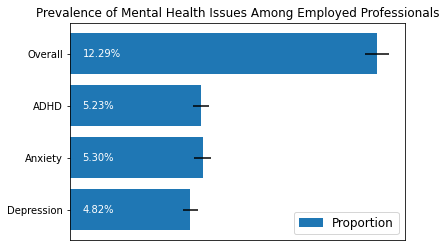

In [ ]:
# Creating a horizontal bar plot of the proportions and errors for each mental health issue
plt.barh(df_mh_pro_plot['issue_type'], df_mh_pro_plot['prop'], xerr=df_mh_pro_plot['prop_err'])
plt.title('Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion', 'Err'], fontsize=12, loc='lower right')
plt.xticks([], [])

# Adding the proportion text for each individual item
for i, v in enumerate(df_mh_pro_plot['prop']):
  plt.text(.005, i, f'{v*100:.2f}%', color='white', va='center')

This analysis shows that 12% of employed professionals responded to the survey that they have mental health issues. This statistic is concerning as it clearly indicates these people have been affected by mental health problems.

### 2. What is the country-specific prevalence of mental health answers among employed professionals?

Identifying how the prevalence of mental health concerns varies between countries can provide valuable insights into the cultural and social factors that influence mental health outcomes.

Like the previous cells, the cells below calculates the percentage of respondents, this time for the 30th most frequently appearing countries. Then create a bar chart of percentages and errors for each country and add percentage text for each individual item and also the errors associated with the 95% confidence level.

In [ ]:
# Country: Creating a new DataFrame with the 30th most frequently appearing country names
# that holds the data for a bar plot showing the proportions of 
# survey responses related to mental health, by country
df_c_plot = df_mh_pro['Country'].value_counts()[:30].to_frame()
df_c_plot.reset_index(inplace=True)
df_c_plot.columns = ['country_name', 'total_mh_samples']

df_top_30 = df[df['Country'].isin(df_c_plot['country_name'])]
total_samples_by_country = df_top_30.groupby('Country').size()
df_c_plot['total_samples'] = df_c_plot['country_name'].map(total_samples_by_country).fillna(0)

df_c_plot['prop'] = df_c_plot['total_mh_samples'] / df_c_plot['total_samples']
df_c_plot = df_c_plot.sort_values('prop').reset_index(drop=True)

In [ ]:
# Calculating the proportions and errors for each country and storing the results in the DataFrame
confidence_lvl_c = proportion_confint(df_c_plot['total_mh_samples'], df_c_plot['total_samples'])
df_c_plot['conf_lo'] = confidence_lvl_c[0]
df_c_plot['conf_hi'] = confidence_lvl_c[1]
df_c_plot['conf_error'] = confidence_lvl_c[1] - confidence_lvl_c[0]

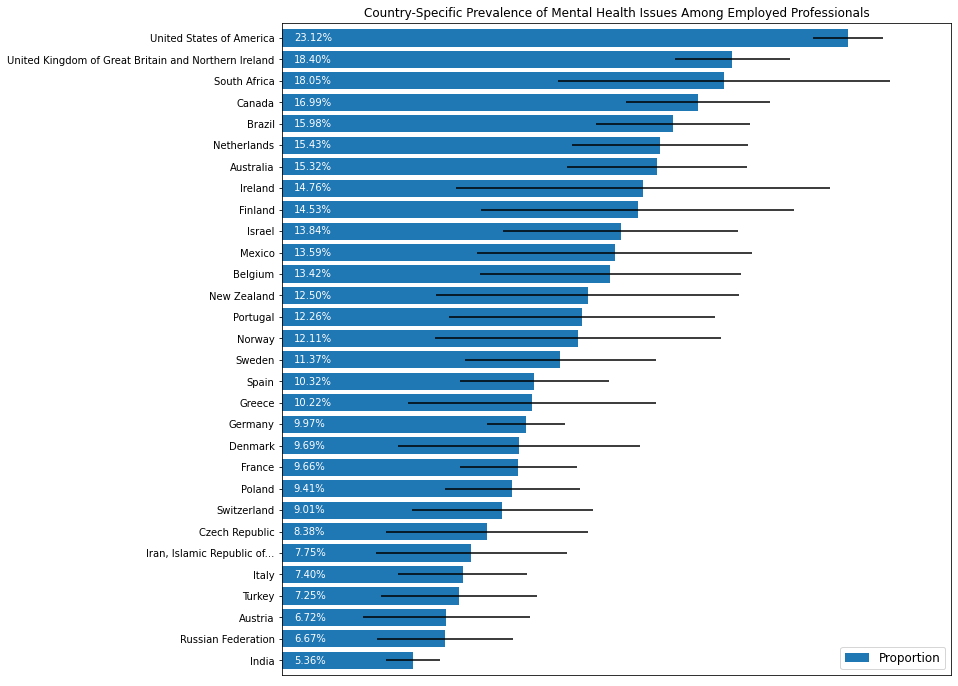

In [ ]:
# Creating a horizontal bar plot of the proportions and errors for each country
plt.figure(figsize=(12,12))
plt.barh(df_c_plot['country_name'], df_c_plot['prop'], xerr=df_c_plot['conf_error'])
plt.title('Country-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion'], fontsize=12, loc='lower right')
plt.xticks([], [])
plt.margins(.1, .01)

# Adding the proportion text for each individual item
for i, v in enumerate(df_c_plot['prop']):
  plt.text(.005, i, f'{v*100:.2f}%', color='white', va='center')

The analysis of the data reveals that there are significant variations in the prevalence of mental health answers among employed professionals across different countries. For instance, the United States has the pole position of respondents (23%) reporting mental health issues, while the United Kingdom has second place in proportion (18%).

### 3. What is the work-model-specific prevalence of mental health answers among employed professionals?

With many professionals moving to remote work due to the current world situation and facilitations, it's important to understand the impact of different work models on mental health outcomes.

The cells below calculates the percentage of survey respondents according to different working models presents on the dataset. Results are displayed in a bar chart, with each work model represented by a separate bar. The graph shows the percentage for each category and the corresponding error bars reflecting the 95% confidence level.

In [ ]:
def get_remote_stats(mental_type):
  """
  Computes the proportion and confidence interval of mental health issues 
  for a specific work model type (e.g. fully remote, in-person, hybrid).
  
  Args:
  - mental_type (str): the type of work model to compute statistics for
  
  Returns:
  - df_remote_prop (float): the proportion of professionals in the dataset with mental health issues for the given work model type
  - df_remote_err (float): the margin of error for the proportion estimate
  """
  df_remote_len = df_mh_pro[df_mh_pro['RemoteWork'] == mental_type].shape[0]
  df_remote_prop = df_remote_len / df_mh_pro_len
  df_remote_err = proportion_confint(df_remote_len, df_mh_pro_len)
  df_remote_err = df_remote_err[1] - df_remote_err[0]
  return df_remote_prop, df_remote_err

In [ ]:
# Creating an empty DataFrame to store the results
df_wm_plot = pd.DataFrame(columns=['remote_type', 'prop', 'prop_err'])

# Computing proportion and confidence interval for each work model type and store the results in the DataFrame
df_inperson_prop, df_inperson_prop_err = get_remote_stats('Full in-person')
df_wm_plot.loc[len(df_wm_plot)] = ['In-Person', df_inperson_prop, df_inperson_prop_err]

df_hybrid_prop, df_hybrid_prop_err = get_remote_stats('Hybrid (some remote, some in-person)')
df_wm_plot.loc[len(df_wm_plot)] = ['Hybrid', df_hybrid_prop, df_hybrid_prop_err]

df_remote_prop, df_remote_prop_err = get_remote_stats('Fully remote')
df_wm_plot.loc[len(df_wm_plot)] = ['Remote', df_remote_prop, df_remote_prop_err]

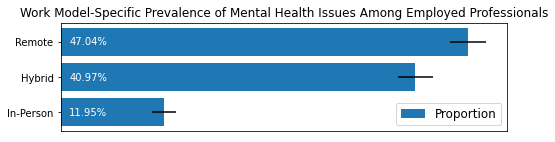

In [ ]:
# Creating a horizontal bar plot of the proportions and errors for each work model
plt.figure(figsize=(8,2))
plt.barh(df_wm_plot['remote_type'], df_wm_plot['prop'], xerr=df_wm_plot['prop_err'])
plt.title('Work Model-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion'], fontsize=12, loc='lower right')
plt.xticks([], [])

# Adding the proportion text for each individual item
for i, v in enumerate(df_wm_plot['prop']):
  plt.text(.01, i, f'{v*100:.2f}%', color='white', va='center')

A small image with huge insightful information. The data suggests that there are big differences in the prevalence of mental health answers among employed professionals based on their work model. Full remote workers have a higher prevalence (47%) of mental health issues than those who work in a Hybrid model (40%) or those who in the office (almost 12%).

### 4. What is the developer-type-specific prevalence of mental health answers among employed professionals?

Developers may face unique stressors and work requirements that can affect their mental health outcomes. Identifying which types of developers are more likely to experience mental health concerns can inform the development of targeted interventions and resources to support these professionals in the workplace.

Next cells creates two DataFrames, one for the entire dataset professionals and one for employed professionals with mental health answers. The reason to have two DataFrames is to calculate the prevalence of mental health answers among employed professionals by developer type and add error bars reflecting the 95% confidence level.

In [ ]:
# Creating two Dev Type DataFrames for:
#   - Entire DataFrame - "df_dt"
#   - Employed Professionals with Mental Health answers - "df_mh_pro_dt"

# For each DataFrames, the below code is:
#   - Filtering the not null values
#   - Spliting the string list by semi-colon
#   - Exploding the values into a single list
#   - Counting the occurrences
df_dt = df[df['DevType'].notna()]
df_dt = df_dt['DevType'].str.split(';').explode()
df_dt_counts = df_dt.value_counts()

df_mh_pro_dt = df_mh_pro[df_mh_pro['DevType'].notna()]
df_mh_pro_dt = df_mh_pro_dt['DevType'].str.split(';').explode()
df_mh_pro_dt_counts = df_mh_pro_dt.value_counts()

# Concatenating both DataFrames into one, reseting the index droping them and creating new columns
df_dv_plot = pd.concat([df_mh_pro_dt_counts, df_dt_counts], axis=1)
df_dv_plot.reset_index(inplace=True)
df_dv_plot.columns = ['dev_type', 'total_mh_samples', 'total_samples']

In [ ]:
# Computing proportion and reseting the index droping them
df_dv_plot['prop'] = df_dv_plot['total_mh_samples'] / df_dv_plot['total_samples']
df_dv_plot = df_dv_plot.sort_values('prop').reset_index(drop=True)

# Computing confidence interval for each dev type and store the results in the DataFrame
confidence_lvl_dv = proportion_confint(df_dv_plot['total_mh_samples'], df_dv_plot['total_samples'])
df_dv_plot['conf_lo'] = confidence_lvl_dv[0]
df_dv_plot['conf_hi'] = confidence_lvl_dv[1]
df_dv_plot['conf_error'] = confidence_lvl_dv[1] - confidence_lvl_dv[0]

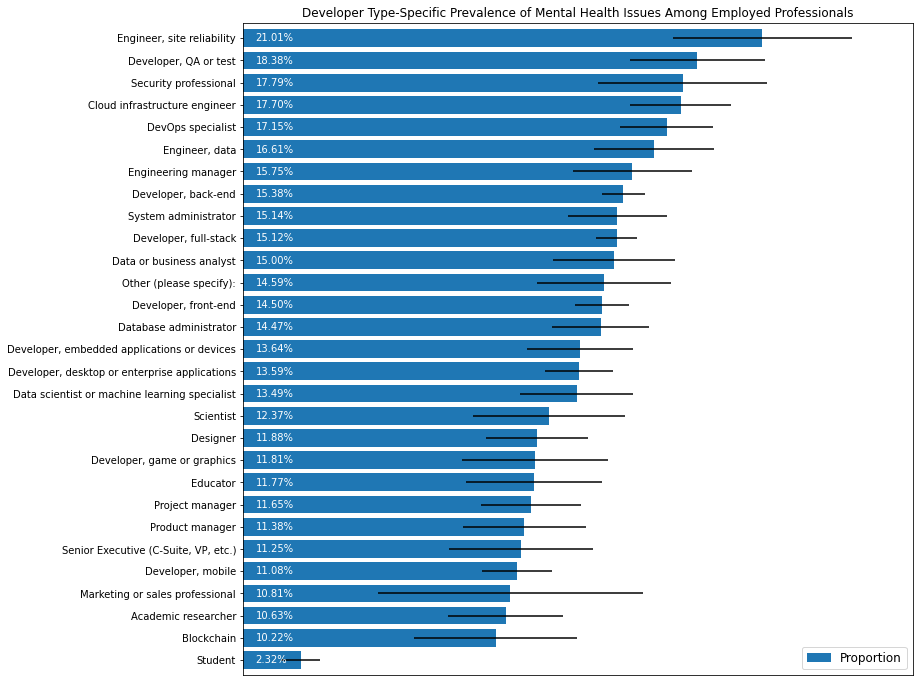

In [ ]:
# Creating a horizontal bar plot of the proportions and errors for each dev type
plt.figure(figsize=(12,12))
plt.barh(df_dv_plot['dev_type'], df_dv_plot['prop'], xerr=df_dv_plot['conf_error'])
plt.title('Developer Type-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion'], fontsize=12, loc='lower right')
plt.xticks([], [])
plt.margins(.1, .01)

# Adding the proportion text for each individual item
for i, v in enumerate(df_dv_plot['prop']):
  plt.text(.005, i, f'{v*100:.2f}%', color='white', va='center')

The data also shows that there are differences in the prevalence of mental health answers among employed professionals based on their developer type. Site Reliability Engineers have the highest prevalence (21%) of mental health issues, followed by others, like the figure below.

### 5. What is the organization’s size-specific prevalence of mental health answers among employed professionals?

Understanding whether there is a correlation between organization size and mental health concerns can inform the development of workplace policies and interventions aimed at promoting mental health in different organizational environments. This information can also help identify potential barriers and facilitators to effective mental health interventions across different organizational sizes.

The next cells analyzes the prevalence of mental health issues among employed professionals by organization size. It creates an organization size label order and computes proportions, confidence intervals, and creates a bi-directional horizontal bar plot to visualize the results. The plot shows the overall answers proportion and only with mental health answers proportion for each organization size.

In [ ]:
# Creating organization size label order
org_order = [
    'I don’t know', 
    'Just me - I am a freelancer, sole proprietor, etc.', 
    '2 to 9 employees', 
    '10 to 19 employees', 
    '20 to 99 employees', 
    '100 to 499 employees', 
    '500 to 999 employees', 
    '1,000 to 4,999 employees', 
    '5,000 to 9,999 employees', 
    '10,000 or more employees']

In [ ]:
# Creating organization size label order
df_mh_org_size = df_mh_pro['OrgSize'].value_counts().reindex(org_order)
df_org_size = df['OrgSize'].value_counts().reindex(org_order)
df_mh_pro_org_size = pd.concat([df_mh_org_size, df_org_size], axis=1)
df_mh_pro_org_size.columns = ['total_mh_samples', 'total_samples']

In [ ]:
"""
Computing proportion for all the entire DataFrame
and for the Employed professionals with Mental Health answers by organization size
"""
df_mh_pro_org_size['prop_all'] = df_mh_pro_org_size['total_samples'] / df_org_size.sum()
df_mh_pro_org_size['prop_mh'] = df_mh_pro_org_size['total_mh_samples'] / df_mh_pro_org_size['total_samples']

# Computing confidence interval for each organizaion size and store the results in the DataFrame
confidence_lvl_o = proportion_confint(df_mh_pro_org_size['total_mh_samples'], df_mh_pro_org_size['total_samples'])
df_mh_pro_org_size['mh_conf_lo'] = confidence_lvl_o[0]
df_mh_pro_org_size['mh_conf_hi'] = confidence_lvl_o[1]
df_mh_pro_org_size['mh_conf_error'] = confidence_lvl_o[1] - confidence_lvl_o[0]

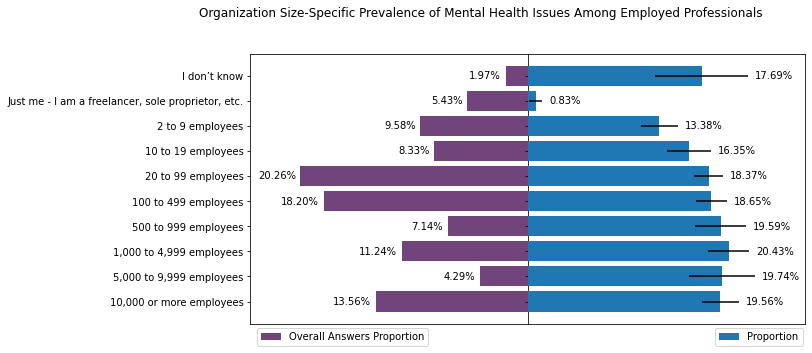

In [ ]:
"""
Creating a bi-directional horizontal bar plot of the 
proportions and errors for each organization size
"""
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout()
fig.suptitle('Organization Size-Specific Prevalence of Mental Health Issues Among Employed Professionals')

# Creating the left plot - Overall answers
axes[0].barh(df_mh_pro_org_size.index, -df_mh_pro_org_size['prop_all'], align='center', color='#71457C', zorder=10)
# Adding the proportion text for each individual item
for i, v in enumerate(-df_mh_pro_org_size['prop_all']):
  axes[0].text(v-.004, i, f'{abs(v*100):.2f}%', color='black', ha='right', va='center', zorder=20)

# Creating the right plot - Only with Mental Health answers
axes[1].barh(df_mh_pro_org_size.index, df_mh_pro_org_size['prop_mh'], xerr=df_mh_pro_org_size['mh_conf_error'], align='center', zorder=10)
# Adding the proportion text for each individual item
for i, v in enumerate(df_mh_pro_org_size[['prop_mh', 'mh_conf_error']].values):
  p = v[1]
  v = v[0]
  axes[1].text(v+p+.007, i, f'{v*100:.2f}%', color='black', ha='left', va='center', zorder=20)

# inverting the Y axis so we can follow the organization size label order
plt.gca().invert_yaxis()

# Removing ticks and labels from the X acis for both plots
axes[0].set_xticks([])
axes[0].set_xticklabels([])
axes[1].set_xticks([])
axes[1].set_xticklabels([])

# Ajusting the margin so it can fits better
axes[0].margins(.22, .05)
axes[1].margins(.22, .05)

# Adding legends for both plots and fixins adjusting the subplots to be side-by-side
axes[0].legend(['Overall Answers Proportion'], fontsize=10, loc='lower left', bbox_to_anchor=(.005, -.10))
axes[1].legend(['Proportion'], fontsize=10, loc='lower right', bbox_to_anchor=(1.01, -.10))
plt.subplots_adjust(wspace=0, top=.85, bottom=.1, left=.18, right=.95)

This analysis reveals that the prevalence of mental health answers among employed professionals is related to the organization's size. In larger organizations with more than 1000 employees, the prevalence of mental health issues is the highest (20%). The figure below shows us these proportions, where the left violet side has the overall proportions (percentual of the total answers) and the right blue side has the proportions with only mental health answers.

### 6. What is the age-specific prevalence of mental health answers among employed professionals?

Understanding how age and different life stages affect mental health in the workplace can inform the development of targeted interventions and resources to support the mental health needs of different generations of professionals. This information can also inform policies aimed at promoting healthy work environments for professionals at different stages of their careers.

The code is performing data analysis on age-specific prevalence of mental health issues among employed professionals. It creates an age label order and reindexes the DataFrame based on this order. Then it drops null values from age analysis and computes proportions for the entire DataFrame and for employed professionals with mental health answers by organization size. It computes confidence intervals for each age range and stores the results in the DataFrame. Finally, it creates a line plot of the proportions and errors (95% confidence leval) for each age range, and adds the proportion text for each individual item for both entire DataFrame and employed professionals with mental health answers.

In [ ]:
# Creating age label order
age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older ',
    'Prefer not to say']

In [ ]:
df_mh_age = df_mh_pro['Age'].value_counts().reindex(age_order)
df_age = df['Age'].value_counts().reindex(age_order)
df_mh_pro_age = pd.concat([df_mh_age, df_age], axis=1)
df_mh_pro_age.columns = ['total_mh_samples', 'total_samples']

# Dropping the null values from age analysis ensures accurate and comprehensive insights
# Null values have no valuable insights at this moment
df_mh_pro_age.dropna(inplace=True)

In [ ]:
# Computing proportion for all the entire DataFrame
# and for the Employed professionals with Mental Health answers by organization size
df_mh_pro_age['prop_all'] = df_mh_pro_age['total_samples'] / df_age.sum()
df_mh_pro_age['prop_mh'] = df_mh_pro_age['total_mh_samples'] / df_mh_pro_age['total_samples']

# Computing confidence interval for each age range and store the results in the DataFrame
confidence_lvl_a = proportion_confint(df_mh_pro_age['total_mh_samples'], df_mh_pro_age['total_samples'])
df_mh_pro_age['mh_conf_lo'] = confidence_lvl_a[0]
df_mh_pro_age['mh_conf_hi'] = confidence_lvl_a[1]
df_mh_pro_age['mh_conf_error'] = confidence_lvl_a[1] - confidence_lvl_a[0]

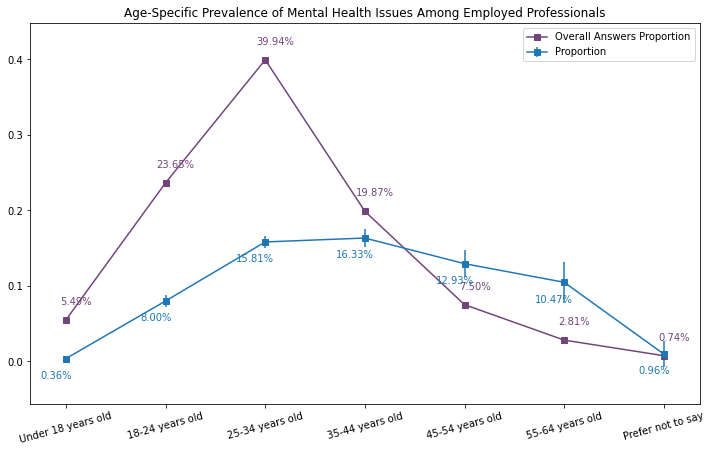

In [ ]:
# Creating holding varibles for entire DataFrame answers by age
xa = df_mh_pro_age.index
ya = df_mh_pro_age['prop_all']

# Creating holding varibles for Employed Professionals with Mental Health answers by age
# and holding variable for the confidence level error
xmh = df_mh_pro_age.index
ymh = df_mh_pro_age['prop_mh']
mh_error = df_mh_pro_age['mh_conf_error']

# Creating a line plot of the 
# proportions and errors for each age range
plt.figure(figsize=(12,7))
plt.title('Age-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.errorbar(xa, ya, fmt='-s', color='#71457C')
plt.errorbar(xmh, ymh, yerr=mh_error, fmt='-s')
plt.legend(['Overall Answers Proportion', 'Proportion'], fontsize=10, loc='upper right')
plt.xticks(rotation = 15)
plt.margins(.06, .12)

# Adding the proportion text for each individual item - Entire DataFrame
for x, y in zip(xa, ya):
    label = f'{y*100:.2f}%'
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(10,15), ha='center', color='#71457C')

# Adding the proportion text for each individual item - Employed Professionals with Mental Health answers
for x, y in zip(xmh, ymh):
    label = f'{y*100:.2f}%'
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(-10,-20), ha='center', color='#1f77b4')

The data suggest that two workers' age ranges (25–34 and 35–44) have a higher prevalence (around 15% and 16%) of mental health issues than older workers (55+) (10%). The following figure shows the age-specific proportions.